In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Importing cleaned data from task 1
df = pd.read_csv("cleaned_data.csv", encoding='latin1')

### So, to extract category from description column we can either:
1 - Extract the last 2 words from the description column and use them as category

2 - Over kill it with an LLM

The first approach is much faster but less precise, Though I would recommend it as it is less costly

## Using the first approach:

In [3]:
import re

# Cleaning Description and removing extra spaces
def clean_text(text):
    # Cleaning text from non-Alphabet words
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # using last 2 words as category
    return " ".join(text.split()[-2:]).lower() # This could also be done by using the last word
df["Categories"] = df["Description"].apply(clean_text)

In [4]:
# Counting unique Categories
len(df["Categories"].unique())

2273

In [5]:
df.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,Categories
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,tlight holder
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,metal lantern


In [6]:
# creating an aggregation for Total price of categories
# ordering from largest revenue to smallest 
df_Cat_total_price = df[['Categories', 'TotalPrice']].groupby('Categories').sum().sort_values(by='TotalPrice', ascending=False)
df_Cat_total_price.head()

,TotalPrice
Categories,
tlight holder,229471.09
metal sign,182766.16
little birdie,168469.60
red retrospot,164710.65
cakestand tier,150969.55


C:\Users\ahmad\AppData\Local\Temp\ipykernel_13572\3129089179.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Categories',


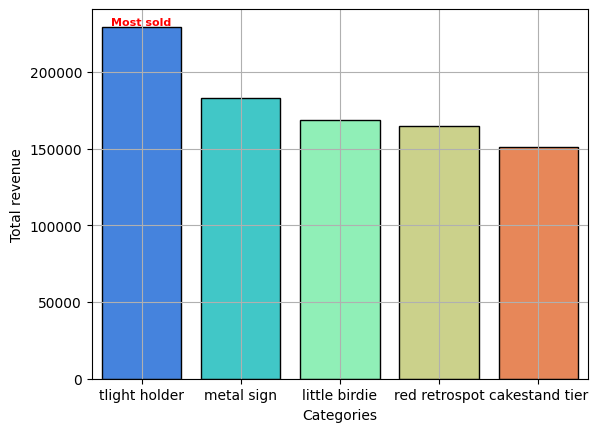

In [7]:
# only keeping top 5 categories, could use .head() too
df_Cat_total_price_top_5 = df_Cat_total_price.iloc[:5].reset_index()
# The bar plot for top 5 categories of revenue
ax = sns.barplot(x='Categories', 
            y='TotalPrice', 
            data=df_Cat_total_price_top_5, 
            palette='rainbow',
            edgecolor='black')
# Changing the label to be more readable
plt.ylabel("Total revenue")

# Adding annotation for top sold
top_bar_index = df_Cat_total_price_top_5['TotalPrice'].idxmax()
top_bar_value = df_Cat_total_price_top_5['TotalPrice'].max()
ax.text(
    top_bar_index, 
    top_bar_value + 5,
    'Most sold', 
    ha='center', 
    va='bottom', 
    fontsize=8, 
    color='red', 
    fontweight='bold',
)
plt.grid()

C:\Users\ahmad\AppData\Local\Temp\ipykernel_13572\747562760.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Categories',


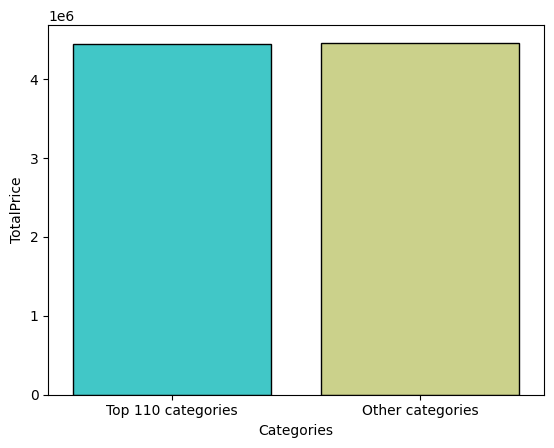

In [8]:
threshhold = 110
top_n = df_Cat_total_price.iloc[:threshhold].sum().values[0]
other = df_Cat_total_price.iloc[threshhold:].sum().values[0]
df_top_n_vs_other = pd.DataFrame([["Top 110 categories",top_n],["Other categories",other]],columns = ['Categories','TotalPrice'])
ax = sns.barplot(x='Categories', 
            y='TotalPrice', 
            data=df_top_n_vs_other, 
            palette='rainbow',
            edgecolor='black')

# From the last plot we conclude that only top 110 categories have revenue as much as the rest of the 2273 categories

### Showcasing the second approach
### This approach has to be finetuned first

In [9]:
from transformers import pipeline

generator = pipeline("text-generation", model="EleutherAI/gpt-neo-125M") # Creating Model instance

Device set to use cuda:0


In [10]:
from time import time
import logging
logging.getLogger('transformers').setLevel(logging.ERROR) # To remove unnecessary loggings

start = time() # Calculating time
# Extracting Categories from Description text using LLM
for desc in df['Description'][:5]:
    prompt = f"This product description: '{desc}' belongs to the category:"
    result = generator(prompt, max_length=30, num_return_sequences=1)
    output = f"{result[0]['generated_text'].split(':')[-1].strip()}"
    print(f"{desc} -> {output}")
print("Time elapsed",(time()-start), 'seconds') # Printing time elapsed

WHITE HANGING HEART T-LIGHT HOLDER -> 'Hair Healing Hair'
WHITE METAL LANTERN -> 'The World's Most Beautiful Metal Layers' and is available
CREAM CUPID HEARTS COAT HANGER -> 'CREAM CUPID
KNITTED UNION FLAG HOT WATER BOTTLE -> 'Korean Water Bottles
RED WOOLLY HOTTIE WHITE HEART. -> 'Red WOOLLY HOTT
Time elapsed 1.1262357234954834 seconds


In [11]:
((len(df)/5)/60)/60 # Calculating time to figure out the whole dataset

22.10688888888889

### That means that it would take the model 22 hours to classify the entire dataset on my machine.
### Smaller models could be useful with finetuning, but this was a showcase of what I think is the right way to do it.